In [1]:
import sklearn.experimental.enable_hist_gradient_boosting
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingClassifier, GradientBoostingRegressor
import pandas as pd
from sklearn.model_selection import cross_validate, train_test_split
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import svm

from surprise import NormalPredictor, SVD, NMF, SlopeOne, CoClustering, KNNBasic, KNNWithZScore, KNNWithMeans, KNNBaseline, SVDpp
from surprise import Dataset
from surprise import Reader
#from surprise.model_selection import cross_validate, RandomizedSearchCV

/Users/leo/opt/anaconda3/envs/nootropics/lib/python3.8/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
df = pd.read_csv('dataset_clean_features.csv')

In [3]:
names, counts = np.unique(df["itemID"], return_counts=True)
indices = np.argsort(counts)[::-1]
print(names[indices])
print(counts[indices])

['Caffeine' 'Melatonin' 'Modafinil' 'Theanine' 'Creatine' 'Nicotine'
 'Adderall' 'Noopept' 'Choline' 'Piracetam' 'Bacopa' 'Ashwagandha'
 'Phenibut' 'Aniracetam' 'Rhodiola' 'Phenylpiracetam' 'Oxiracetam'
 'Tianeptine' 'SemaxandNASemaxetc' 'LSD' 'Coluracetam' 'Inositol' 'DMAE'
 'Uridine' 'Picamilon' 'SelankandNASelanketc' 'PRL853' 'Seligiline'
 'Fasoracetam' 'MethyleneBlue' 'Epicorasimmunebooster'
 'AlphaBrainproprietaryblend' 'Emoxypine' 'Unifiram' 'Cerebrolysin'
 'Dihexa']
[769 480 480 455 352 342 314 312 307 289 225 218 216 211 206 196 165 145
 124 109 100  97  84  78  70  68  48  45  45  39  37  36  29  26  22  20]


In [4]:
prop_val = 0.2
indices = np.array(list(range(len(df))))
np.random.shuffle(indices)
train_indices, val_indices, test_indices = indices[:int(0.5 * len(indices))],  indices[int(0.5 * len(indices)):int((0.5 + prop_val) * len(indices))], indices[int((0.5 + prop_val) * len(indices)):]

ct = ColumnTransformer(
    [("categorical", OneHotEncoder(sparse=False), ['itemID', "userID", 'MentalHealthAnxiety', "Age", 'MentalHealthDepression', 'MentalHealthADHD', 'Sex'])])

X = ct.fit_transform(df.drop(["CountryofResidence", "rating", ], axis=1))

y = df["rating"]

X_train, X_test, X_val, y_train, y_test, y_val = X[train_indices], \
                                                 X[test_indices], \
                                                 X[val_indices], \
                                                 y[train_indices], \
                                                 y[test_indices], \
                                                 y[val_indices]

df_surprise_train = df[["userID", "itemID", "rating"]].iloc[train_indices]
df_surprise_test = df[["userID", "itemID", "rating"]].iloc[test_indices]
df_surprise_val = df[["userID", "itemID", "rating"]].iloc[val_indices]
df_surprise_train_val = df[["userID", "itemID", "rating"]].iloc[list(train_indices) + list(val_indices)]

In [5]:
suprise_model_1 = KNNBaseline(k=60, min_k=2, sim_options={'name': 'pearson_baseline', 'user_based': True})
suprise_model_2 = SVD(**{'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.1})


# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 10))

# The columns must correspond to user id, item id and ratings (in that order).
new_trainset = Dataset.load_from_df(df_surprise_train, reader).build_full_trainset()
new_trainset_val = Dataset.load_from_df(df_surprise_train_val, reader).build_full_trainset()

In [6]:
res_df = pd.DataFrame()
n = 20


In [7]:
for _ in range(20):
    res_dic = {}
    suprise_model_1.fit(new_trainset)
    suprise_model_2.fit(new_trainset)
    prediction_surprise_1 = lambda row: suprise_model_1.predict(uid=row["userID"], iid=row["itemID"]).est
    prediction_surprise_2 = lambda row: suprise_model_2.predict(uid=row["userID"], iid=row["itemID"]).est
    val_predictions_surprise_1 = df_surprise_val.apply(prediction_surprise_1, axis=1)
    test_predictions_surprise_1 = df_surprise_test.apply(prediction_surprise_1, axis=1)
    val_predictions_surprise_2 = df_surprise_val.apply(prediction_surprise_2, axis=1)
    test_predictions_surprise_2 = df_surprise_test.apply(prediction_surprise_2, axis=1)

    X_val_both = np.concatenate((val_predictions_surprise_1.values.reshape(-1, 1), val_predictions_surprise_2.values.reshape(-1, 1)), axis=1)
    X_test_both = np.concatenate((test_predictions_surprise_1.values.reshape(-1, 1), test_predictions_surprise_2.values.reshape(-1, 1)), axis=1)
    clf_stacking = RandomForestRegressor()
    clf_stacking.fit(X_val_both, y_val)

    res_dic["stacking_rmse"] = mean_squared_error(y_test, clf_stacking.predict(X_test_both), squared=False)
    res_dic["stacking_mae"] = mean_absolute_error(y_test, clf_stacking.predict(X_test_both))

    X_val_KNN = val_predictions_surprise_1.values.reshape(-1, 1)
    X_test_KNN = test_predictions_surprise_1.values.reshape(-1, 1)
    clf_stacking_KNN = RandomForestRegressor()
    clf_stacking_KNN.fit(X_val_KNN, y_val)

    res_dic["stacking_KNN_rmse"] = mean_squared_error(y_test, clf_stacking_KNN.predict(X_test_KNN), squared=False)
    res_dic["stacking_KNN_mae"] = mean_absolute_error(y_test, clf_stacking_KNN.predict(X_test_KNN))

    X_val_SVD = val_predictions_surprise_2.values.reshape(-1, 1)
    X_test_SVD = test_predictions_surprise_2.values.reshape(-1, 1)
    clf_stacking_SVD = RandomForestRegressor()
    clf_stacking_SVD.fit(X_val_SVD, y_val)

    res_dic["stacking_SVD_rmse"] = mean_squared_error(y_test, clf_stacking_SVD.predict(X_test_SVD), squared=False)
    res_dic["stacking_SVD_mae"] = mean_absolute_error(y_test, clf_stacking_SVD.predict(X_test_SVD))

    clf_stacking_features_SVD = RandomForestRegressor()
    suprise_model_2.fit(new_trainset_val)
    train_val_predictions_surprise_2 = df_surprise_train_val.apply(prediction_surprise_2, axis=1)
    clf_stacking_features_SVD.fit(np.concatenate((train_val_predictions_surprise_2.values.reshape(-1, 1),
                                                  np.concatenate((X_train, X_val), axis=0)), axis=1),
                                  np.concatenate((y_train, y_val), axis=0))
    y_hat_test = clf_stacking_features_SVD.predict(np.concatenate((test_predictions_surprise_2.values.reshape(-1, 1), X_test), axis=1))
    res_dic["stacking_features_SVD_rmse"] = mean_squared_error(y_test, y_hat_test, squared=False)
    res_dic["stacking_features_SVD_mae"] = mean_absolute_error(y_test, y_hat_test)



    suprise_model_1.fit(new_trainset_val)
    suprise_model_2.fit(new_trainset_val)
    test_predictions_surprise_1 = df_surprise_test.apply(prediction_surprise_1, axis=1)
    test_predictions_surprise_2 = df_surprise_test.apply(prediction_surprise_2, axis=1)
    res_dic["surprise_KNN_test_rmse"] = mean_squared_error(y_test, test_predictions_surprise_1, squared=False)
    res_dic["surprise_KNN_test_mae"] = mean_absolute_error(y_test, test_predictions_surprise_1)

    res_dic["surprise_SVD_test_rmse"] = mean_squared_error(y_test, test_predictions_surprise_2, squared=False)
    res_dic["surprise_SVD_test_mae"] = mean_absolute_error(y_test, test_predictions_surprise_2)

    clf = RandomForestRegressor(**{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 100}) #best param #TODO automate
    clf.fit(np.concatenate((X_train, X_val), axis=0),
        np.concatenate((y_train, y_val), axis=0))
    y_hat_test = clf.predict(X_test)
    res_dic["clf_rmse"] = mean_squared_error(y_test, y_hat_test, squared=False)
    res_dic["clf_mae"] = mean_absolute_error(y_test, y_hat_test)


    clf = DummyRegressor()
    clf.fit(np.concatenate((X_train, X_val), axis=0),
    np.concatenate((y_train, y_val), axis=0))
    y_hat_test = clf.predict(X_test)
    res_dic["clf_dummy_rmse"] = mean_squared_error(y_test, y_hat_test, squared=False)
    res_dic["clf_dummy_mae"] = mean_absolute_error(y_test, y_hat_test)

    clf = GradientBoostingRegressor()
    clf.fit(np.concatenate((X_train, X_val), axis=0),
    np.concatenate((y_train, y_val), axis=0))
    y_hat_test = clf.predict(X_test)
    res_dic["clf_gbt_rmse"] = mean_squared_error(y_test, y_hat_test, squared=False)
    res_dic["clf_gbt_mae"] = mean_absolute_error(y_test, y_hat_test)


    clf.fit(X_train, y_train)
    clf_stacking_features = RandomForestRegressor()
    clf_stacking_features.fit(np.concatenate((clf.predict(X_val).reshape(-1, 1), X_val_KNN), axis=1),
                              y_val)
    y_hat_test = clf_stacking_features.predict(np.concatenate((clf.predict(X_test).reshape(-1, 1), X_test_KNN), axis=1))
    res_dic["stacking_clf_KNN_rmse"] = mean_squared_error(y_test, y_hat_test, squared=False)
    res_dic["stacking_clf_KNN_mae"] = mean_absolute_error(y_test, y_hat_test)

    clf.fit(X_train, y_train)
    clf_stacking_features = RandomForestRegressor()
    clf_stacking_features.fit(np.concatenate((clf.predict(X_val).reshape(-1, 1), X_val_SVD), axis=1),
                              y_val)
    y_hat_test = clf_stacking_features.predict(np.concatenate((clf.predict(X_test).reshape(-1, 1), X_test_SVD), axis=1))
    res_dic["stacking_clf_SVD_rmse"] = mean_squared_error(y_test, y_hat_test, squared=False)
    res_dic["stacking_clf_SVD_mae"] = mean_absolute_error(y_test, y_hat_test)


    res_df = res_df.append(res_dic, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [8]:
new_df = pd.DataFrame({"mean": res_df.mean(),
                       "CI-": res_df.mean() - 2 * res_df.std() / np.sqrt(n),
                       "CI+":res_df.mean() + 2*res_df.std() /np.sqrt(n)})

In [9]:
new_df

,mean,CI-,CI+
clf_dummy_mae,2.269242,2.269242,2.269242
clf_dummy_rmse,2.748912,2.748912,2.748912
clf_gbt_mae,2.045608,2.045027,2.046190
clf_gbt_rmse,2.523690,2.522920,2.524459
clf_mae,1.976782,1.975402,1.978162
clf_rmse,2.451472,2.450106,2.452838
stacking_KNN_mae,2.357951,2.356484,2.359418
stacking_KNN_rmse,2.976350,2.974695,2.978005
stacking_SVD_mae,2.310883,2.300045,2.321722
stacking_SVD_rmse,2.917315,2.904880,2.929751


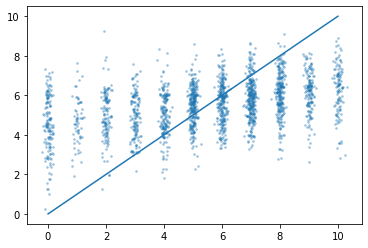

In [10]:
import matplotlib.pyplot as plt
plt.scatter(y_test + np.random.normal(0, 0.08, len(y_test)), X_test_KNN, alpha=0.3, s=3)
#plt.scatter(y_test+ np.random.normal(0, 0.08, len(y_test)), clf_stacking_KNN.predict(X_test_KNN), alpha=0.3, s=3)
plt.plot([0, 10], [0, 10])

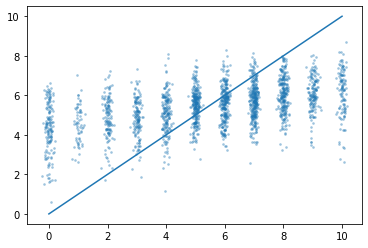

In [11]:
plt.scatter(y_test + np.random.normal(0, 0.08, len(y_test)), X_test_SVD, alpha=0.3, s=3)
#plt.scatter(y_test+ np.random.normal(0, 0.08, len(y_test)), clf_stacking_KNN.predict(X_test_KNN), alpha=0.3, s=3)
plt.plot([0, 10], [0, 10])

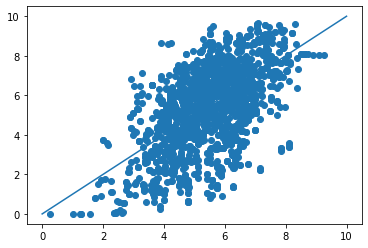

In [12]:
plt.scatter(X_test_KNN, clf_stacking_KNN.predict(X_test_KNN))
plt.plot([0, 10], [0, 10])

In [13]:
clf = RandomForestRegressor(**{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 100}) #best param #TODO automate
clf.fit(np.concatenate((X_train, X_val), axis=0),
        np.concatenate((y_train, y_val), axis=0))
y_hat_test = clf.predict(X_test)

In [14]:
print(mean_squared_error(y_test, y_hat_test, squared=False))
print(mean_absolute_error(y_test, y_hat_test))

2.4504865672684453
1.972818397059785


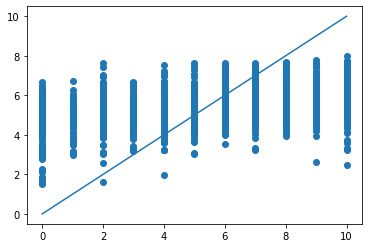

In [15]:
plt.scatter(y_test, y_hat_test)
plt.plot([0, 10], [0, 10])